<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Creating%20data%20frames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and drive access

In [180]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import boxcox
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [28]:
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/MyDrive/CoganLab/Neighbourhood

 D71_Block_1_TrialData.mat	  eeg_all.csv
'D72_Block_1_TrialData (1).mat'   eeg_no_outliers.csv
 D72_Block_1_TrialData.mat	  ieeg_all.csv
'D73_Block_1_TrialData (1).mat'   ieeg_subset.csv
 D73_Block_1_TrialData.mat	  Subject_NeighborhoodSternberg_EEG_060322.mat
 D77_Block_1_TrialData.mat	  Subject_NeighborhoodSternberg_IEEG_060322.mat
 D79_Block_1_TrialData.mat


In [6]:
working_path = Path('/content/gdrive/MyDrive/CoganLab/Neighbourhood')

In [7]:
# controls' data
eeg = scipy.io.loadmat(
    working_path.joinpath('Subject_NeighborhoodSternberg_EEG_060322.mat')
    )
# patients' data
ieeg = scipy.io.loadmat(
    working_path.joinpath('Subject_NeighborhoodSternberg_IEEG_060322.mat')
    )
new_subject72 = scipy.io.loadmat(
    working_path.joinpath('D72_Block_1_TrialData.mat')
    )
new_subject73 = scipy.io.loadmat(
    working_path.joinpath('D73_Block_1_TrialData.mat')
    )
new_subject77 = scipy.io.loadmat(
    working_path.joinpath('D77_Block_1_TrialData.mat')
    )
new_subject79 = scipy.io.loadmat(
    working_path.joinpath('D79_Block_1_TrialData.mat')
    )

# iEEG dataset 

In [8]:
data_ieeg = ieeg['Subject'] # contains trials for each of the subjects
print('Number of subjects in EEG dataset is', data_ieeg.shape[1])

Number of subjects in EEG dataset is 30


In [9]:
subjects_ieeg = [] # subject numbers
for i in data_ieeg['Name'][0]:
  subjects_ieeg.append(i[0])

In [10]:
def get_to_df(data):
  # this function reads into .mat file and creates df out of it for all of the trials of one subject
  # i'm planning on making it more beautiful later

  columns = data[0][1].dtype.names
  df = pd.DataFrame(columns=columns)
  df['Trial'] = np.nan
  df_ = df.copy()
  for i in range(0, data.shape[1]): # for each trial number
    mdtype = data[0][i].dtype
    values = []
    for name in mdtype.names:
      values.append(data[0][i][name])
    values = extra_arrays(values)
    values.append(str(i)) # adding a trial number at the end
    df_.loc[len(df_.index)] = values
  return df_

In [11]:
def extra_arrays(x):
  # elements have nested structure, i.e. arrays inside the arrays
  # below we're getting rid of this depending on the shape of values

  values = []
  for elem in range(0, len(x)):
    var = x[elem]
    var = var[0, 0]
    if var.shape == (1, 1):
      var = var[0, 0]
      values.append(var)
    elif var.shape == (1,):
      values.append(var[0])
    elif var.shape == (1, 5):
      var = var.tolist()[0]
      values.append(var)
    elif var.shape == (5, 1):
      new = []
      for i in var:
        i = i[0]
        new.append(i)
      values.append(new)
    else:
      values.append(var)
  return values

In [12]:
columns_ieeg = data_ieeg['trialInfo'][0, 0][0, 0].dtype.names # name of the variables from trial info
final_ieeg = pd.DataFrame(columns=columns_ieeg)
final_ieeg['Trial'] = np.nan
final_ieeg['Subject'] = np.nan
for subj in range(0, data_ieeg['trialInfo'].shape[1]): # for each subject
  print(subj)
  subj_df = get_to_df(data_ieeg['trialInfo'][0, subj])
  subj_df['Subject'] = subjects_ieeg[subj]
  final_ieeg = pd.concat([final_ieeg, subj_df], axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [14]:
# D72 subject
d72 = get_to_df(new_subject72['trialInfo'])
d73 = get_to_df(new_subject73['trialInfo'])
d77 = get_to_df(new_subject77['trialInfo'])
d79 = get_to_df(new_subject79['trialInfo'])

In [15]:
d72['Subject'] = 'D72'
d73['Subject'] = 'D73'
d77['Subject'] = 'D77'
d79['Subject'] = 'D79'

In [16]:
ieeg = pd.concat([final_ieeg, d72])
ieeg = pd.concat([ieeg, d73])
ieeg = pd.concat([ieeg, d77])
ieeg = pd.concat([ieeg, d79])

In [17]:
len(ieeg.Subject.unique())

34

In [18]:
ieeg.Subject.unique()

array(['D23', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D33', 'D34',
       'D35', 'D36', 'D38', 'D39', 'D41', 'D42', 'D47', 'D48', 'D49',
       'D53', 'D54', 'D55', 'D57', 'D59', 'D61', 'D63', 'D65', 'D68',
       'D69', 'D70', 'D71', 'D72', 'D73', 'D77', 'D79'], dtype=object)

In [19]:
# saving only ieeg dataset anew
ieeg.to_csv(
    Path(working_path).joinpath('ieeg_all.csv')
)

#Preprocessing iEEG dataset

In [ ]:
#ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [144]:
ieeg.isnull().sum()

block                       0
ProbeType                   0
ProbeTypeName               0
StimlusCategory             0
ReactionTime                0
KeyCode                     0
Resp                        0
RespCorrect                 0
Omission                  160
stimulusAudioStart          0
stimulusAlignedTrigger      0
probeAudioStart             0
probeAlignedTrigger         0
TriggerValue                0
stimulusSounds_idx          0
stimulusSounds_name         0
ProbeCategory               0
probeSound_idx              0
probeSound_name             0
Trial                       0
Subject                     0
ListenCueTime             953
MaintenancePeriodTime     953
ProbeCueTime              953
dtype: int64

In [145]:
ieeg.shape

(5460, 24)

In [146]:
ieeg.Subject.unique()

array(['D23', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D33', 'D34',
       'D35', 'D36', 'D38', 'D39', 'D41', 'D42', 'D47', 'D48', 'D49',
       'D53', 'D54', 'D55', 'D57', 'D59', 'D61', 'D63', 'D65', 'D68',
       'D69', 'D70', 'D71', 'D72', 'D73', 'D77', 'D79'], dtype=object)

In [147]:
ieeg.columns

Index(['block', 'ProbeType', 'ProbeTypeName', 'StimlusCategory',
       'ReactionTime', 'KeyCode', 'Resp', 'RespCorrect', 'Omission',
       'stimulusAudioStart', 'stimulusAlignedTrigger', 'probeAudioStart',
       'probeAlignedTrigger', 'TriggerValue', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'Trial', 'Subject', 'ListenCueTime',
       'MaintenancePeriodTime', 'ProbeCueTime'],
      dtype='object')

In [148]:
ieeg_subset = ieeg[[
                 'Trial', 'Subject', 'block', 'ProbeType', 'probeSound_idx',
                 'ProbeTypeName', 'StimlusCategory', 'ReactionTime', 'KeyCode',
                 'Resp', 'RespCorrect', 'Omission', 'ProbeCategory',
                  'stimulusSounds_idx', 'stimulusSounds_name', 'probeSound_name'              
]]

In [149]:
ieeg_subset.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,Low Words,"[[29, 25, 30]]","[[[wash.wav]], [[sure.wav]], [[youth.wav]]]",wash.wav
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,High Words,"[[2, 5, 8, 4, 7, 10, 3]]","[[[debt.wav]], [[lair.wav]], [[seek.wav]], [[g...",lair.wav
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,High Non-Words,"[[19, 14, 18, 16, 20, 15, 17]]","[[[rihn.wav]], [[kehl.wav]], [[rehl.wav]], [[p...",paon.wav
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,Low Words,"[[10, 2, 7, 9, 1, 8, 6, 5, 4]]","[[[witch.wav]], [[debt.wav]], [[pawn.wav]], [[...",wash.wav
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,High Words,"[30, 24, 25, 29, 21]","[[youth.wav], [noun.wav], [sure.wav], [wash.wa...",soar.wav


In [150]:
# check if any of the subjects is less than 75 % accurate
checkset = ieeg_subset.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
(checkset < 0.75).any()

RespCorrect    True
dtype: bool

In [151]:
options_drop = checkset[checkset['RespCorrect'] < 0.75].index
checkset = checkset.reset_index()

print('The subjects with accuracy less than 75 %')
print(options_drop)
x = []
for i in checkset.Subject.values:
  for j in options_drop:
    if i == j:
      x.append(checkset.loc[checkset['Subject'] == i][['RespCorrect']].values[0][0])
print(x)

The subjects with accuracy less than 75 %
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70', 'D77'], dtype='object', name='Subject')
[0.70625, 0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.71875, 0.725]


In [152]:
ieeg_subset[ieeg_subset['Resp'] == 'No Response']

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
9,9,D23,1,2,39,in_sequence,Low Non-words,2.502478,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-words,"[[32, 37, 31, 39, 40, 35, 33, 38, 36]]","[[[faez.wav]], [[wehz.wav]], [[deech.wav]], [[...",yuwf.wav
19,19,D23,1,1,40,out_of_sequence,High Non-Words,2.502283,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[17, 19, 18, 13, 15, 12, 16]]","[[[puwn.wav]], [[rihn.wav]], [[rehl.wav]], [[k...",zerth.wav
26,26,D23,1,1,33,out_of_sequence,High Non-Words,2.502340,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[13, 18, 14]]","[[[kawl.wav]], [[rehl.wav]], [[kehl.wav]]]",gawth.wav
32,32,D23,2,2,25,in_sequence,Low Words,2.502395,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Words,"[[30, 22, 25, 29, 21, 23, 24, 28, 27]]","[[[youth.wav]], [[fudge.wav]], [[sure.wav]], [...",sure.wav
97,97,D23,4,1,36,out_of_sequence,High Non-Words,2.502652,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[16, 17, 18]]","[[[paon.wav]], [[puwn.wav]], [[rehl.wav]]]",vern.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,D79,2,1,35,out_of_sequence,High Non-Words,2.501854,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-Words,"[18, 16, 11, 13, 20]","[[rehl.wav], [paon.wav], [dehs.wav], [kawl.wav...",kuv.wav
63,63,D79,2,1,24,out_of_sequence,High Words,2.501430,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[[2, 8, 1]]","[[[debt.wav]], [[seek.wav]], [[cop.wav]]]",noun.wav
108,108,D79,4,2,27,in_sequence,Low Words,2.501380,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[30, 21, 27, 25, 28]","[[youth.wav], [fog.wav], [tube.wav], [sure.wav...",tube.wav
120,120,D79,4,2,34,in_sequence,Low Non-words,2.501415,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-words,"[[32, 34, 38]]","[[[faez.wav]], [[jhong.wav]], [[yong.wav]]]",jhong.wav


In [153]:
ieeg_subset[ieeg_subset['Omission'] != 'Responded']
# let's keep these NaNs since all the other information is there 

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
9,9,D23,1,2,39,in_sequence,Low Non-words,2.502478,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-words,"[[32, 37, 31, 39, 40, 35, 33, 38, 36]]","[[[faez.wav]], [[wehz.wav]], [[deech.wav]], [[...",yuwf.wav
19,19,D23,1,1,40,out_of_sequence,High Non-Words,2.502283,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[17, 19, 18, 13, 15, 12, 16]]","[[[puwn.wav]], [[rihn.wav]], [[rehl.wav]], [[k...",zerth.wav
26,26,D23,1,1,33,out_of_sequence,High Non-Words,2.502340,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[13, 18, 14]]","[[[kawl.wav]], [[rehl.wav]], [[kehl.wav]]]",gawth.wav
32,32,D23,2,2,25,in_sequence,Low Words,2.502395,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Words,"[[30, 22, 25, 29, 21, 23, 24, 28, 27]]","[[[youth.wav]], [[fudge.wav]], [[sure.wav]], [...",sure.wav
97,97,D23,4,1,36,out_of_sequence,High Non-Words,2.502652,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[16, 17, 18]]","[[[paon.wav]], [[puwn.wav]], [[rehl.wav]]]",vern.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,D79,2,1,35,out_of_sequence,High Non-Words,2.501854,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-Words,"[18, 16, 11, 13, 20]","[[rehl.wav], [paon.wav], [dehs.wav], [kawl.wav...",kuv.wav
63,63,D79,2,1,24,out_of_sequence,High Words,2.501430,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[[2, 8, 1]]","[[[debt.wav]], [[seek.wav]], [[cop.wav]]]",noun.wav
108,108,D79,4,2,27,in_sequence,Low Words,2.501380,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[30, 21, 27, 25, 28]","[[youth.wav], [fog.wav], [tube.wav], [sure.wav...",tube.wav
120,120,D79,4,2,34,in_sequence,Low Non-words,2.501415,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-words,"[[32, 34, 38]]","[[[faez.wav]], [[jhong.wav]], [[yong.wav]]]",jhong.wav


In [154]:
print(ieeg_subset[ieeg_subset['Omission'] != 'Responded'].Subject.unique())

['D23' 'D26' 'D27' 'D28' 'D30' 'D31' 'D33' 'D34' 'D35' 'D36' 'D38' 'D39'
 'D41' 'D42' 'D47' 'D48' 'D49' 'D53' 'D54' 'D55' 'D57' 'D59' 'D61' 'D63'
 'D65' 'D68' 'D69' 'D70' 'D71' 'D72' 'D73' 'D77' 'D79']


Creating additional variables

In [155]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in ieeg_subset.ProbeCategory.values:
  new_probe.append(i.lower())
ieeg_subset['ProbeCategory'] = new_probe

<ipython-input-155-df1cb0339cf5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['ProbeCategory'] = new_probe


In [160]:
ieeg_subset.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[[29, 25, 30]]","[[[wash.wav]], [[sure.wav]], [[youth.wav]]]",wash.wav
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[[2, 5, 8, 4, 7, 10, 3]]","[[[debt.wav]], [[lair.wav]], [[seek.wav]], [[g...",lair.wav
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[[19, 14, 18, 16, 20, 15, 17]]","[[[rihn.wav]], [[kehl.wav]], [[rehl.wav]], [[p...",paon.wav
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[[10, 2, 7, 9, 1, 8, 6, 5, 4]]","[[[witch.wav]], [[debt.wav]], [[pawn.wav]], [[...",wash.wav
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]","[[youth.wav], [noun.wav], [sure.wav], [wash.wa...",soar.wav


In [161]:
# making values in df more 'handy'
whole_list = ieeg_subset['stimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  if type(i) is list:
    new_sound_idx.append(i)
  elif type(i) is np.ndarray:
    new_sound_idx.append(i[0].tolist())
  else:
    print(type(i))
    print(len(new_sound_idx))
    break

In [162]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[3, 7, 9, 5]


In [163]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = ieeg_subset['probeSound_idx'].values
in_out = ieeg_subset['ProbeTypeName'].values
for i in range(0, len(ind)):
  if in_out[i] == 'in_sequence': # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 'out_of_sequence':
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [164]:
length = []
for i in ieeg_subset.stimulusSounds_idx:
  length.append(len(i))

In [165]:
ieeg_subset['Position'] = positions
ieeg_subset['Length'] = length

<ipython-input-165-b7de9913c462>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Position'] = positions
<ipython-input-165-b7de9913c462>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Length'] = length


In [166]:
lex = []
phon = []
for i in ieeg_subset.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in ieeg_subset.ProbeCategory.values:
  if 'low' in i: # high = 0 low = 1 
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

5460
5460


In [167]:
ieeg_subset['Lex'] = lex
ieeg_subset['Phono'] = phon

<ipython-input-167-aefbe34290ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Lex'] = lex
<ipython-input-167-aefbe34290ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Phono'] = phon


## Stats on iEEG

In [187]:
print('The shape of the iEEG dataset with "No Response" trials', ieeg_subset.shape)
print('The accuracy', ieeg_subset.RespCorrect.mean())
print('The shape of the iEEG dataset without "No Response" trials', ieeg_subset[ieeg_subset['Resp'] != 'No Response'].shape)
print('The accuracy', ieeg_subset[ieeg_subset['Resp'] != 'No Response'].RespCorrect.mean())

The shape of the iEEG dataset with "No Response" trials (5460, 20)
The accuracy 0.7882783882783883
The shape of the iEEG dataset without "No Response" trials (5230, 20)
The accuracy 0.822944550669216


In [190]:
checkset = ieeg_subset.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)

In [194]:
options_drop1 = checkset[checkset['RespCorrect'] < 0.75].index
new1 = checkset.reset_index()
print('The subjects with accuracy less than 75 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new1.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new1.loc[new1['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg1 = ieeg[
                        (ieeg['Subject'] != 'D30') &
                        (ieeg['Subject'] != 'D33') &
                        (ieeg['Subject'] != 'D49') &
                        (ieeg['Subject'] != 'D54') &
                        (ieeg['Subject'] != 'D61') &
                        (ieeg['Subject'] != 'D65') &
                        (ieeg['Subject'] != 'D70') &
                        (ieeg['Subject'] != 'D77')
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg1.RespCorrect.mean())
print('')
options_drop1 = checkset[checkset['RespCorrect'] < 0.70].index
new2 = checkset.reset_index()
print('The subjects with accuracy less than 70 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new2.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new2.loc[new2['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg2 = ieeg[
                        (ieeg['Subject'] != 'D33') &
                        (ieeg['Subject'] != 'D49') &
                        (ieeg['Subject'] != 'D54') &
                        (ieeg['Subject'] != 'D61') &
                        (ieeg['Subject'] != 'D65')                       
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg2.RespCorrect.mean())
print('')

The subjects with accuracy less than 75 %
The dataset with "No response" trials
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70', 'D77'], dtype='object', name='Subject')
[0.70625, 0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.71875, 0.725]
Poor performers 8
Accuracy without poor performers 0.8360221526607272

The subjects with accuracy less than 70 %
The dataset with "No response" trials
Index(['D33', 'D49', 'D54', 'D61', 'D65'], dtype='object', name='Subject')
[0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65]
Poor performers 5
Accuracy without poor performers 0.8236563781567019



In [195]:
ieeg2.shape

(4633, 24)

In [196]:
print(
    'No response trials in the dataset: ',
    ieeg2[ieeg2['Resp'] == 'No Response'].shape[0]
)

No response trials in the dataset:  109


Looking into outliers

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


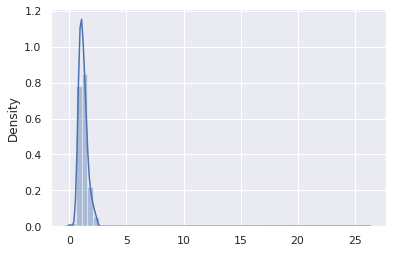

In [197]:
sns.distplot(ieeg2[ieeg2['Resp'] != 'No Response'][['ReactionTime']].values);

In [198]:
print('In seconds')
print(
    'mean', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.mean(),
    'max', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.max(),
    'min', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.min())

In seconds
mean 1.1947806766927411 max 26.115354993380606 min 0.016333818435668945


In [199]:
# kicking out all the trials (13) that are below 150 msec, two of the are no response trials
ieeg_no_outliers = ieeg2[ieeg2['ReactionTime'] > 0.15]

In [200]:
# kicking out the trial of 26 sec, only 1 
ieeg_no_outliers = ieeg_no_outliers[ieeg_no_outliers['ReactionTime'] < 25]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D23 Max 2.5044814660213888 Min 0.5284106724429876


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D26 Max 2.248248639079975 Min 0.7032921151840128


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D27 Max 2.5040557351894677 Min 0.8089978282805532


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D28 Max 2.5024784363340586 Min 0.5284106724429876
D29 Max 2.390633505769074 Min 0.7759903273545206


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D30 Max 2.5042315841419622 Min 0.6001890921761515
D31 Max 2.5029665574547835 Min 1.010608747776132


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D34 Max 2.5029558130481746 Min 0.33149156073341146


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


D35 Max 2.50634925061604 Min 0.42535340442555025
D36 Max 2.502573014283712 Min 0.5638364125347834
D38 Max 2.5024061138974503 Min 0.6113873518770561
D39 Max 2.5027801612159237 Min 0.7234540177159943


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

D41 Max 2.5019888426177204 Min 0.7655674288980663
D42 Max 2.5025993096642196 Min 0.8343088356778026
D47 Max 2.503154328718665 Min 0.9056599745672429
D48 Max 2.50514738484344 Min 0.6624780359707074


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

D53 Max 2.5029803460929543 Min 0.7813855952117592
D55 Max 2.502972317219246 Min 0.6055784318014048
D57 Max 2.5020663738250732 Min 0.5506687164306641
D59 Max 2.502418279647827 Min 0.7078800201416016


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

D63 Max 2.5026211738586426 Min 0.5341362953186035
D68 Max 2.5023014545440674 Min 0.45386528968811035
D69 Max 2.5028154850006104 Min 0.6867258548736572
D70 Max 2.5027525424957275 Min 0.8827483654022217


<ipython-input-201-fd3f42b24f4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-201-fd3f42b24f4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()
/usr/local/

D71 Max 2.502472162246704 Min 0.6448314189910889
D72 Max 2.502131700515747 Min 0.5349686145782471
D73 Max 2.502854347229004 Min 0.4883263111114502
D77 Max 2.5020134449005127 Min 0.9331631660461426


<ipython-input-201-fd3f42b24f4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-201-fd3f42b24f4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  pl.figure()
/usr/local/

D79 Max 2.501854419708252 Min 0.8440937995910645


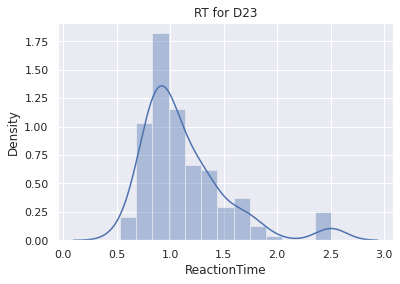

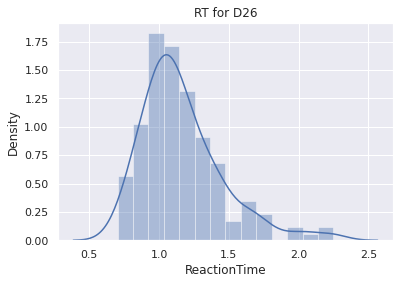

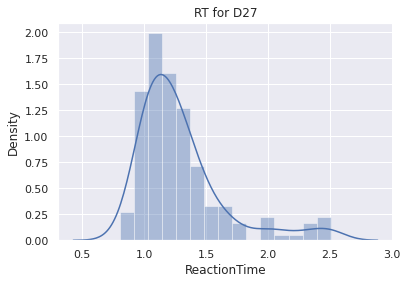

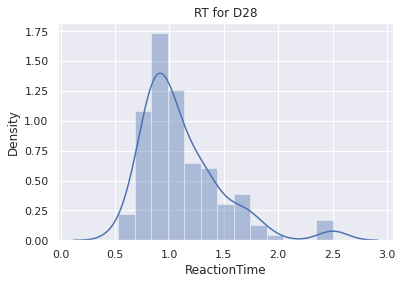

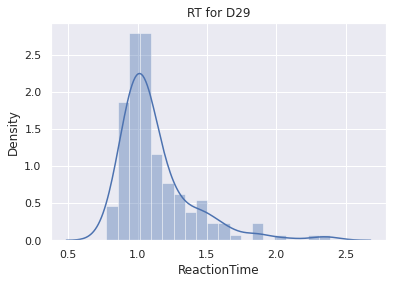

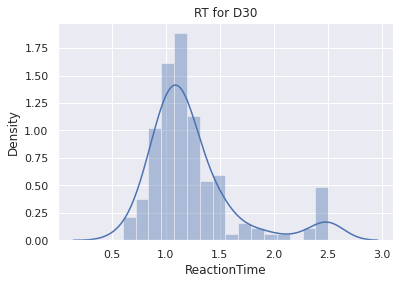

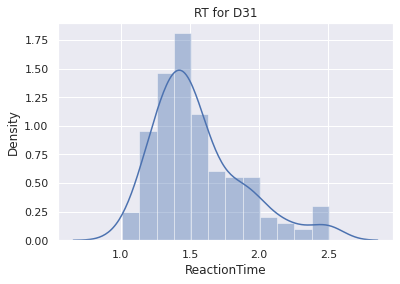

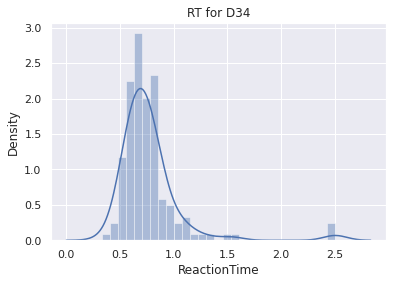

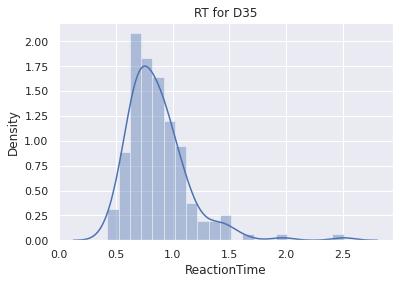

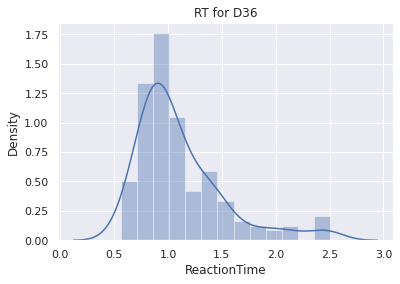

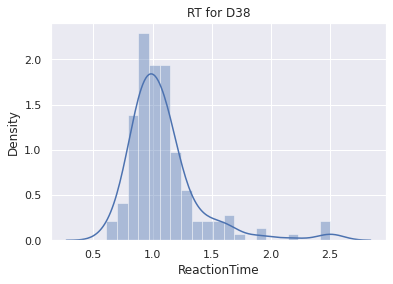

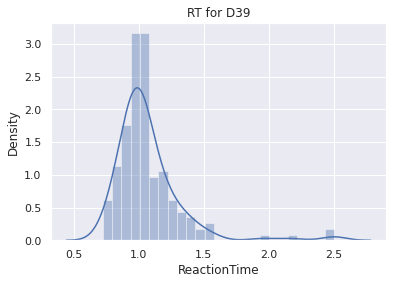

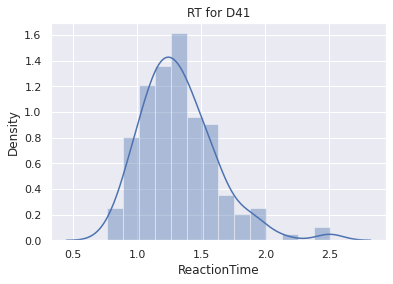

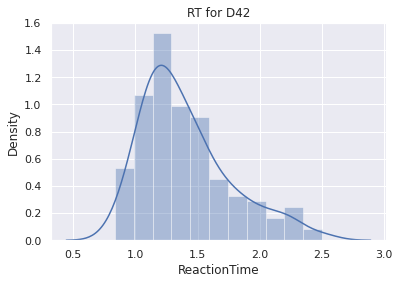

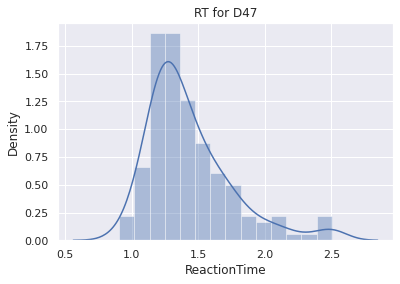

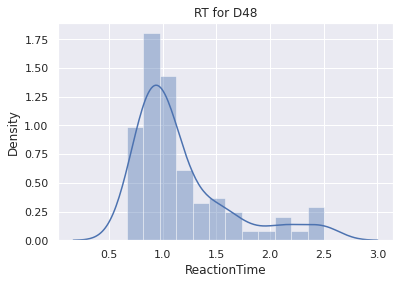

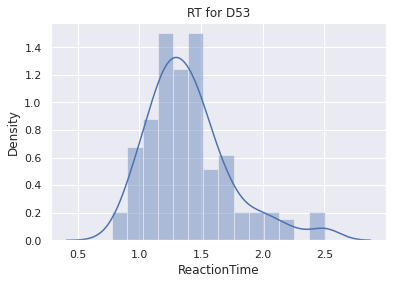

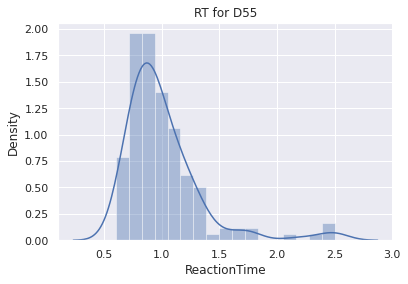

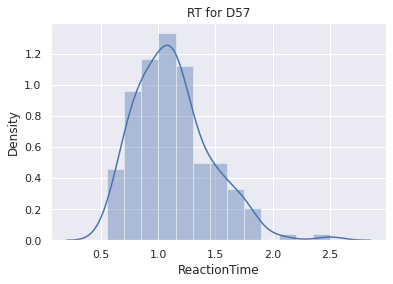

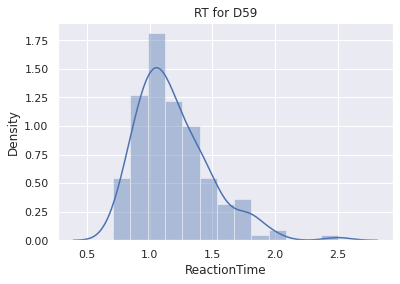

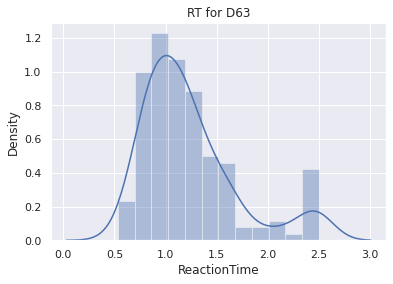

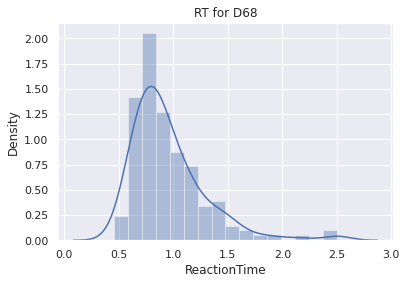

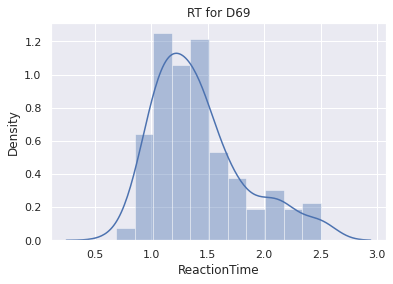

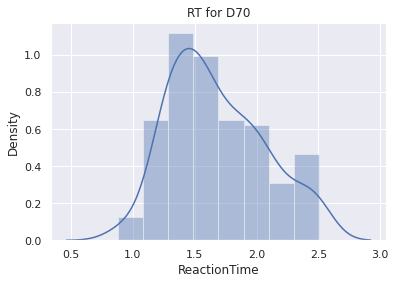

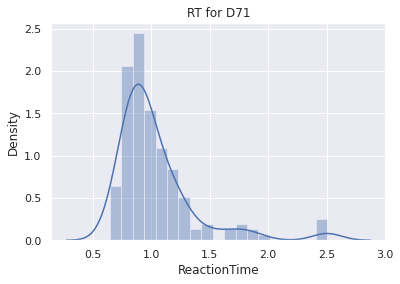

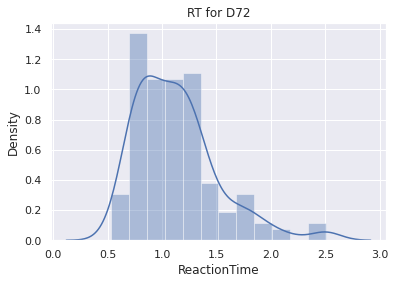

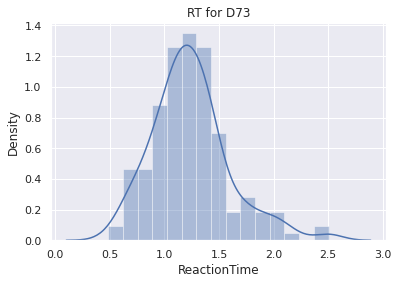

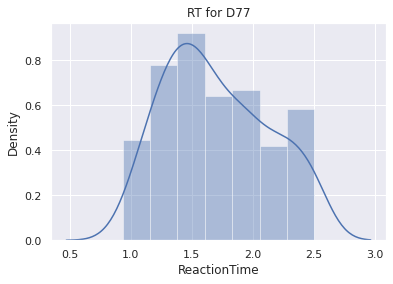

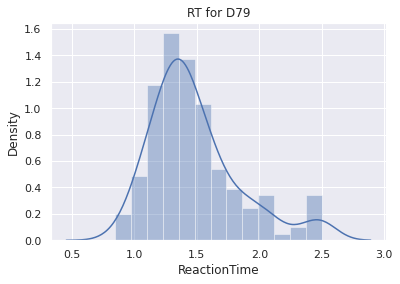

In [201]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.distplot(subset[subset['Resp'] != ' No Response'].ReactionTime)
  pl.title('RT for ' + i);
  print(i, 'Max', subset[subset['Resp'] != ' No Response'].ReactionTime.max(), 'Min', subset[subset['Resp'] != ' No Response'].ReactionTime.min())

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 1.1920713232503108 Max 2.4904961585998535 Min 0.33149156073341146


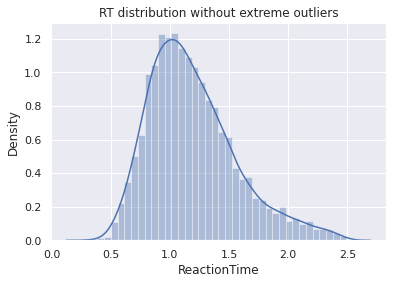

In [202]:
sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime)
pl.title('RT distribution without extreme outliers');
print(
    'Mean', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.mean(),
    'Max', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.max(),
    'Min', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.min()
)

In [203]:
values = []
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  q75 = np.percentile(subset[subset['Resp'] != 'No Response']['ReactionTime'], 75)
  q25 = np.percentile(subset[subset['Resp'] != 'No Response']['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset[subset['Resp'] != 'No Response'].ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

D23 0
D26 2
D27 3
D28 0
D29 3
D30 2
D31 0
D34 2
D35 1
D36 0
D38 3
D39 2
D41 0
D42 0
D47 0
D48 3
D53 0
D55 2
D57 0
D59 0
D63 0
D68 1
D69 0
D70 0
D71 3
D72 0
D73 0
D77 0
D79 0


In [204]:
len(values)

27

In [205]:
print(shapiro(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values))
print(normaltest(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values))

ShapiroResult(statistic=0.9559968709945679, pvalue=6.996135430051905e-35)
NormaltestResult(statistic=441.2596120492818, pvalue=1.5194719949807615e-96)


In [206]:
fitted_data_, fitted_lambda_ = boxcox(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


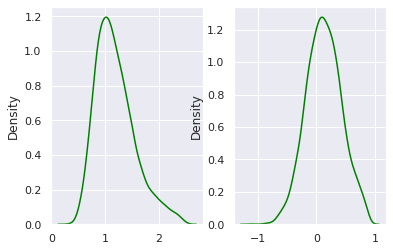

In [207]:
fig, ax = plt.subplots(1, 2)
sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data_, hist = False, kde = True,
            label = "Normal", color ="green", ax = ax[1]);

In [208]:
print(shapiro(fitted_data_))
print(normaltest(fitted_data_))
print(fitted_lambda_)

ShapiroResult(statistic=0.998046338558197, pvalue=1.903061638586223e-05)
NormaltestResult(statistic=5.647214038555502, pvalue=0.05939133021291109)
-0.032817818771241326


In [209]:
ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['stdRT'] = fitted_data_

<ipython-input-209-1ab00667bd79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['stdRT'] = fitted_data_


In [211]:
# saving result
ieeg_no_outliers.to_csv(
    Path(working_path).joinpath('ieeg_processed.csv')
)

# EEG dataset

In [20]:
data_eeg = eeg['Subject'] # contains trials for each of the subjects
print('Number of subjects in EEG dataset is', data_eeg.shape[1])

Number of subjects in EEG dataset is 29


In [21]:
subjects_eeg = [] # subject numbers
for i in range(0, data_eeg.shape[1]):
  name = data_eeg[0, i]['Name'][0][0][0]
  subjects_eeg.append(name)

In [22]:
columns_eeg = data_eeg[0, 0]['trialInfo'][0, 0].dtype.names # name of the variables from trial info
final_eeg = pd.DataFrame(columns=columns_eeg)
final_eeg['Trial'] = np.nan
final_eeg['Subject'] = np.nan
for subj in range(0, data_eeg.shape[1]): # for each subject
  print(subj)
  subj_df = get_to_df(data_eeg[0, subj]['trialInfo'][0, 0])
  subj_df['Subject'] = subjects_eeg[subj]
  final_eeg = pd.concat([final_eeg, subj_df], axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [23]:
final_eeg.columns

Index(['Trial', 'Subject', 'Block', 'ProbeType', 'ProbeTypeName',
       'StimulusCategory', 'ListenCue', 'ReactionTime', 'KeyCode', 'Response',
       'ResponseCorrect', 'Omission', 'StimulusAudioStart',
       'StimulusAlignedTrigger', 'DelayPeriodOnset', 'MaintenancePeriodOnset',
       'ProbeCueOnset', 'ProbeAudioStart', 'ProbeAlignedTrigger',
       'TriggerValueCondition', 'StimulusSounds_idx', 'StimulusSounds_name',
       'ProbeCategory', 'ProbeSound_idx', 'ProbeSound_name'],
      dtype='object')

#Preprocessing EEG dataset

In [ ]:
'''eeg = pd.read_csv(
    working_path.joinpath('eeg_all.csv'),
    index_col=None
)'''

In [110]:
eeg = final_eeg.copy()

In [31]:
eeg.columns

Index(['Trial', 'Subject', 'Block', 'ProbeType', 'ProbeTypeName',
       'StimulusCategory', 'ListenCue', 'ReactionTime', 'KeyCode', 'Response',
       'ResponseCorrect', 'Omission', 'StimulusAudioStart',
       'StimulusAlignedTrigger', 'DelayPeriodOnset', 'MaintenancePeriodOnset',
       'ProbeCueOnset', 'ProbeAudioStart', 'ProbeAlignedTrigger',
       'TriggerValueCondition', 'StimulusSounds_idx', 'StimulusSounds_name',
       'ProbeCategory', 'ProbeSound_idx', 'ProbeSound_name'],
      dtype='object')

In [ ]:
#eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [32]:
eeg.isnull().sum()

Trial                       0
Subject                     0
Block                       0
ProbeType                   0
ProbeTypeName               0
StimulusCategory            0
ListenCue                   0
ReactionTime              100
KeyCode                     0
Response                    0
ResponseCorrect             0
Omission                    0
StimulusAudioStart          0
StimulusAlignedTrigger      0
DelayPeriodOnset            0
MaintenancePeriodOnset      0
ProbeCueOnset               0
ProbeAudioStart             0
ProbeAlignedTrigger         0
TriggerValueCondition       0
StimulusSounds_idx          0
StimulusSounds_name         0
ProbeCategory               0
ProbeSound_idx              0
ProbeSound_name             0
dtype: int64

In [33]:
print(len(eeg.Subject.unique()))
print(eeg.shape)

29
(5568, 25)


In [111]:
eeg_subset = eeg[[
                 'Trial', 'Subject', 'Block', 'ProbeType', 'ProbeSound_idx',
                 'ProbeTypeName', 'StimulusCategory', 'ReactionTime', 'KeyCode',
                 'Response', 'ResponseCorrect', 'Omission', 'ProbeCategory',
                  'StimulusSounds_name', 'ProbeSound_name', 'StimulusSounds_idx'                 
]]

In [91]:
eeg_subset.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx
0,0,E2,1,1,21,out_of_sequence,High Words,NaN,2.Left3.Left,No Response,0,No Response,Low Words,"[[mon.wav], [pcn.wav], [sik.wav], [kap.wav], [...",Sur.wav,"[6, 7, 8, 4, 10]"
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,Low Non-words,"[[yuf.wav], [JcG.wav], [kuv.wav], [wEz.wav], [...",ycG.wav,"[39, 32, 35, 37, 38]"
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,Low Words,"[[[tub.wav]], [[fcg.wav]], [[f^j.wav]], [[lcG....",yuT.wav,"[[27, 23, 22, 24, 25, 29, 26, 28, 30]]"
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,High Words,"[[fEl.wav], [lEr.wav], [sik.wav], [kap.wav], [...",lEr.wav,"[2, 5, 8, 4, 6]"
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,High Non-Words,"[[[gWT.wav]], [[kuv.wav]], [[vRn.wav]], [[zRT....",g@n.wav,"[[34, 35, 36, 40, 39, 33, 37]]"


In [92]:
# check whether any response accuracy is less than 75%
(eeg_subset.groupby(['Subject'])['ResponseCorrect'].mean() < 0.75).any()

False

In [39]:
eeg_subset.groupby(['Subject'])['ResponseCorrect'].mean()

Subject
E10    0.911458
E11    0.895833
E12    0.859375
E13    0.833333
E15    0.817708
E16    0.890625
E17    0.791667
E18    0.947917
E2     0.875000
E20    0.817708
E21    0.812500
E22    0.833333
E23    0.864583
E24    0.828125
E25    0.833333
E26    0.843750
E27    0.765625
E28    0.901042
E29    0.817708
E3     0.885417
E30    0.885417
E31    0.890625
E33    0.953125
E4     0.791667
E5     0.880208
E6     0.755208
E7     0.864583
E8     0.875000
E9     0.921875
Name: ResponseCorrect, dtype: float64

In [112]:
whole_list = eeg_subset['StimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  if type(i) is list:
    new_sound_idx.append(i)
  elif type(i) is np.ndarray:
    new_sound_idx.append(i[0].tolist())
  else:
    print(type(i))
    print(len(new_sound_idx))
    break

In [113]:
eeg_subset['StimulusSounds_idx'] = new_sound_idx

<ipython-input-113-6042217f2404>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['StimulusSounds_idx'] = new_sound_idx


In [114]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[5, 9, 7, 3]


In [115]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = eeg_subset['ProbeSound_idx'].values
in_out = eeg_subset['ProbeType'].values
for i in range(0, len(ind)):
  if in_out[i] == 2: # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 1:
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [116]:
length = []
for i in eeg_subset.StimulusSounds_idx:
  length.append(len(i))

In [117]:
eeg_subset['Position'] = positions
eeg_subset['Length'] = length

<ipython-input-117-25a45b78502a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Position'] = positions
<ipython-input-117-25a45b78502a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Length'] = length


In [118]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in eeg_subset.ProbeCategory.values:
  new_probe.append(i.lower())
eeg_subset['ProbeCategory'] = new_probe

<ipython-input-118-07ed8a5c37a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['ProbeCategory'] = new_probe


Standardizing RT

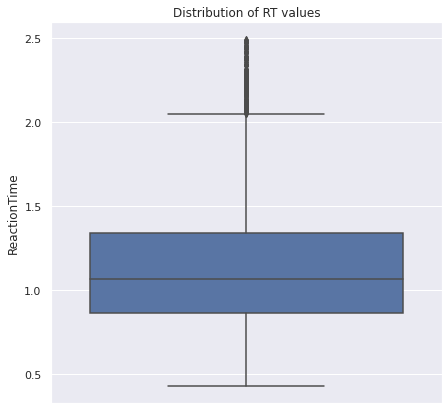

In [119]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=eeg_subset)
pl.title("Distribution of RT values");

In [120]:
# check for outliers outside 
eeg_no_outliers = eeg_subset.copy()
q75 = np.percentile(eeg_no_outliers['ReactionTime'], 75)
q25 = np.percentile(eeg_no_outliers['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
index = 0
for value in eeg_no_outliers['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
    index += 1
  elif value > upper:
    col_new.append(np.nan)
    index += 1
  else:
    col_new.append(value)
print(index)

0


No outliers in the EEG dataset

In [134]:
# standardization with RT without outliers 
rt = eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.values
rt_mean = rt.mean()
rt_std = rt.std()
newRT = []
for i in eeg_subset.ReactionTime.values:
  if math.isnan(i) == True:
    newRT.append(i)
  else:
    newRT.append((i - rt_mean)/rt_std)

In [135]:
eeg_subset['stdRT'] = newRT

<ipython-input-135-af2a9f2fc113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['stdRT'] = newRT


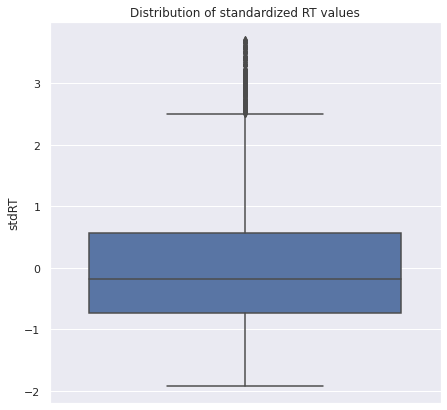

In [138]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="stdRT", data=eeg_subset)
pl.title("Distribution of standardized RT values");

<Figure size 1440x720 with 0 Axes>

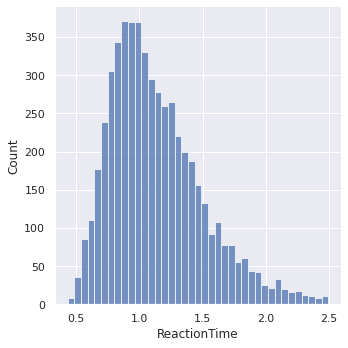

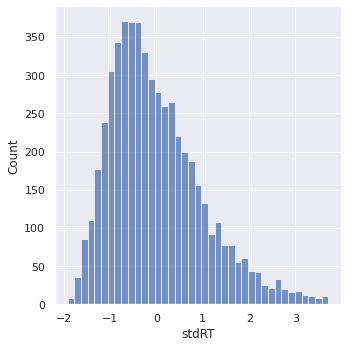

In [139]:
# upper plot - with outliers, lower plots - without
pl.figure(figsize = (20, 10))
sns.displot(eeg_subset['ReactionTime']);
sns.displot(eeg_subset['stdRT']);

In [140]:
lex = []
phon = []
for i in eeg_subset.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in eeg_subset.ProbeCategory.values:
  if 'low' in i: # low = 1 high = 0
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

5568
5568


In [142]:
eeg_subset['Lex'] = lex
eeg_subset['Phono'] = phon

<ipython-input-142-900deb494d65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Lex'] = lex
<ipython-input-142-900deb494d65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Phono'] = phon


##Stats on EEG

In [171]:
print(
    'Accuracy without "No response" trials',
    eeg_subset[eeg_subset['Response'] != 'No Response'].ResponseCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg_subset.ResponseCorrect.mean()
)
    

Accuracy without "No response" trials 0.8723482077542063
Accuracy with "No response" trials 0.8566810344827587


In [173]:
print('Shape of the dataset with no response trials', eeg_subset.shape)
print('Shape of the dataset without no response trials', eeg_subset[eeg_subset['Response'] != 'No Response'].shape)

Shape of the dataset with no response trials (5568, 21)
Shape of the dataset without no response trials (5468, 21)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 1.1349431817298263 Max 2.492920639537033 Min 0.43356203194434784


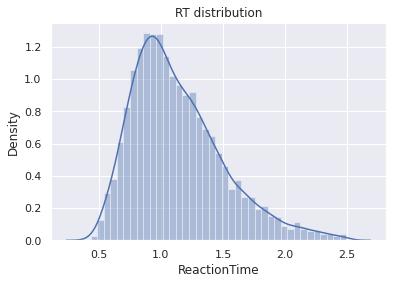

In [174]:
sns.distplot(eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime)
pl.title('RT distribution');
print(
    'Mean', eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.mean(),
    'Max', eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.max(),
    'Min', eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.min()
)

In [176]:
values = []
for i in eeg_subset[eeg_subset['Response'] != 'No Response'].Subject.unique():
  subset = eeg_subset[eeg_subset['Response'] != 'No Response']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

E2 2
E3 0
E4 0
E5 0
E6 3
E7 5
E8 3
E9 7
E10 6
E11 1
E12 1
E13 0
E15 0
E16 2
E17 0
E18 4
E20 1
E21 0
E22 0
E23 2
E24 2
E25 1
E26 0
E27 0
E28 0
E29 0
E30 0
E31 0
E33 7


In [177]:
len(values)

47

In [181]:
# check for normality of the distribution
test = shapiro(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values)
if test[1] > 0.05:
  print('Probably Gaussian')
else:
  print('Probably not Gaussian')

Probably not Gaussian


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [182]:
normaltest(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values)

NormaltestResult(statistic=619.6311037347008, pvalue=2.8107059705027285e-135)

In [183]:
fitted_data, fitted_lambda = boxcox(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


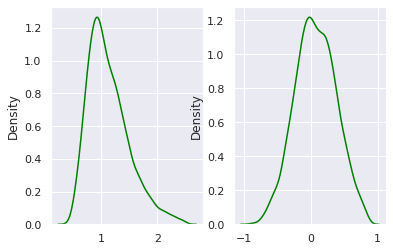

In [184]:
fig, ax = pl.subplots(1, 2)
sns.distplot(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            label = "Normal", color ="green", ax = ax[1]);

In [185]:
eeg_subset[eeg_subset['Response'] != 'No Response']['stdRT'] = fitted_data

<ipython-input-185-beae636ae5d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset[eeg_subset['Response'] != 'No Response']['stdRT'] = fitted_data


In [186]:
print(fitted_lambda)
print('Shapiro test:', shapiro(fitted_data))
print('Other normal test:', normaltest(fitted_data))

-0.14836812286618403
Shapiro test: ShapiroResult(statistic=0.9975175857543945, pvalue=8.745944057864108e-08)
Other normal test: NormaltestResult(statistic=39.477175381694096, pvalue=2.6769501589031745e-09)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'No Response' trials are coded as incorrect in the data already, so we don't need to recode this.

In [210]:
# saving result
eeg_subset.to_csv(
    Path(working_path).joinpath('eeg_processed.csv')
)